In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import lstm_models as models

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, CuDNNLSTM, CuDNNGRU, LSTM, GRU, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
import re
import zipfile

Using TensorFlow backend.


Only keeping the needed columns.

In [3]:
def read_csv(prefix=''):
    train_data = pd.read_csv('../data/{}train_data.csv'.format(prefix), encoding='ISO-8859-1', keep_default_na=False)
    dev_data = pd.read_csv('../data/{}dev_data.csv'.format(prefix), encoding='ISO-8859-1', keep_default_na=False)
    test_data = pd.read_csv('../data/{}test_data.csv'.format(prefix), encoding='ISO-8859-1', keep_default_na=False)
    return train_data, dev_data, test_data

train_data, dev_data, test_data = read_csv('no_stemming_')

In [6]:
train_data.head(10)

,text,sentiment
0,can someone fix twitter please smell of aquati...,0
1,just walked up stopped story escalator at peac...,0
2,yes theres proof two lovebirds going to enjoy,4
3,im so sorry youtube video accidentally deleted...,0
4,want to go home now come back on thursday,0
5,mmmm shamrat arrived,4
6,going round aunites in pool x,4
7,cheers buddy will good seeing last night bit o...,4
8,sorry to hear will come kick ass in days if wa...,0
9,think time to retire saab,0


In [4]:
X_train = train_data['text'].values
X_dev = dev_data['text'].values
X_test = test_data['text'].values

print('train_data: ' + str(len(X_train)))
print('dev_data: ' + str(len(X_dev)))
print('test_data: ' + str(len(X_test)))

train_data: 1024000
dev_data: 256000
test_data: 320000


In [5]:
max_fatures = 20000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X_train)

In [6]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train)

X_dev = tokenizer.texts_to_sequences(X_dev)
X_dev = pad_sequences(X_dev, maxlen=X_train.shape[1])

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=X_train.shape[1])

In [7]:
print('The shape of X_train: {}'.format(X_train.shape))
print('The shape of X_dev: {}'.format(X_dev.shape))
print('The shape of X_test: {}'.format(X_test.shape))

The shape of X_train: (1024000, 111)
The shape of X_dev: (256000, 111)
The shape of X_test: (320000, 111)


In [8]:
Y_train = pd.get_dummies(train_data['sentiment']).values
Y_dev = pd.get_dummies(dev_data['sentiment']).values
Y_test = pd.get_dummies(test_data['sentiment']).values

print('The shape of Y_train: {}'.format(Y_train.shape))
print('The shape of Y_dev: {}'.format(Y_dev.shape))
print('The shape of Y_test: {}'.format(Y_test.shape))

The shape of Y_train: (1024000, 2)
The shape of Y_dev: (256000, 2)
The shape of Y_test: (320000, 2)


In [42]:
np.save('../sequence/x_train_word_20000', X_train)
np.save('../sequence/x_dev_word_20000', X_dev)
np.save('../sequence/x_test_word_20000', X_test)
np.save('../sequence/y_train', Y_train)
np.save('../sequence/y_dev', Y_dev)
np.save('../sequence/y_test', Y_test)

In [3]:
max_features = 10000
X_train = np.load('../sequence/x_train_word_{}.npy'.format(max_features))
X_dev = np.load('../sequence/x_dev_word_{}.npy'.format(max_features))
X_test = np.load('../sequence/x_test_word_{}.npy'.format(max_features))
Y_train = np.load('../sequence/y_train.npy')
Y_dev = np.load('../sequence/y_dev.npy')
Y_test = np.load('../sequence/y_test.npy')

We should explore LSTM, CuDNNLSTM, GRU, CuDNNGRU cells. CuDNN cells have following limitations: 1. The activation function has to be `tanh`. 2. It doesn't support dropout.

In [10]:
# Hyperparameters tuning for LSTM: https://arxiv.org/pdf/1707.06799.pdf
max_fatures = 10000
embed_dim = 200
lstm_out = 128
input_length = X_train.shape[1]
epochs = 6
# This is the sweet spot from experiments, but not sharply better than a larger value.
batch_size = 64
# Why 0.5: https://www.reddit.com/r/MachineLearning/comments/3oztvk/why_50_when_using_dropout/
# Variational Dropout: https://arxiv.org/pdf/1512.05287.pdf
input_dropout = 0.5
recurrent_dropout = 0.5
embedding_layer = Embedding(max_fatures, embed_dim, input_length=input_length)

## CuDNNLSTM

In [15]:
params = {
    'model_type': CuDNNLSTM,
    'batch_size': 64,
    'embedding_type': 'randomly initialized',
    'embedding_dim': 200,
    'embedding_max_features': 10000,
    'embedding_word_index': None,
    'embedding_pretrained_zip_path': None,
    'embedding_pretrained_name': None,
    'epoch': 5,
    'rnn_dim': 100,
    'rnn_layer_num': 1,
    'input_length': X_train.shape[1],
    'input_dropout': 0.5,
    'recurrent_dropout': None,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'is_bidirectional': True,
}

model = models.get_model(params)
history = model.fit(
    X_train, Y_train, epochs=params['epoch'], batch_size=params['batch_size'], validation_data=[X_dev, Y_dev])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 99, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 99, 200)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               241600    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 402       
Total params: 2,242,002
Trainable params: 2,242,002
Non-trainable params: 0
_________________________________________________________________
None
Train on 1024000 samples, validate on 256000 samples
Epoch 1/5
 - 669s - loss: 0.4353 - acc: 0.7972 - val_loss: 0.4137 - val_acc: 0.8107
Epoch 2/5
 - 669s - loss: 0.4030 - acc: 0.8158 - val_loss: 0.4066 - val_acc: 0.8163
Epoch 3/5
 - 669s - loss: 0.3897 - acc

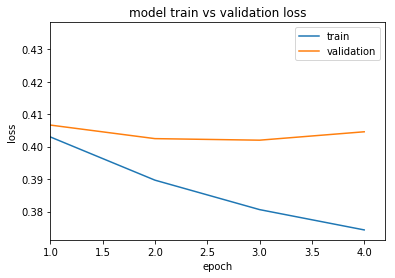

score: 0.40240706
acc: 0.81894375


In [16]:
models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, batch_size = params['batch_size'])
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

## CuDNNLSTM with Glove Embedding

In [9]:
params = {
    'model_type': CuDNNLSTM,
    'batch_size': 64,
    'embedding_type': 'pretrained',
    'embedding_dim': 200,
    'embedding_max_features': 20000,
    'embedding_word_index': tokenizer.word_index,
    'embedding_pretrained_zip_path': '../embeddings/glove.twitter.27B.zip',
    'embedding_pretrained_name': 'glove.twitter.27B.200d.txt',
    'epoch': 5,
    'rnn_dim': 100,
    'rnn_layer_num': 1,
    'input_length': X_train.shape[1],
    'input_dropout': 0.5,
    'recurrent_dropout': None,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'is_bidirectional': True,
}

model = models.get_model(params)
history = model.fit(
    X_train, Y_train, epochs=params['epoch'], batch_size=params['batch_size'], validation_data=[X_dev, Y_dev])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 111, 200)          74377000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 111, 200)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               241600    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 74,619,002
Trainable params: 74,619,002
Non-trainable params: 0
_________________________________________________________________
None
Train on 1024000 samples, validate on 256000 samples
Epoch 1/5
1024000/1024000 [==============================] - 2063s 2ms/step - loss: 0.4305 - acc: 0.7994 - val_loss: 0.3992 - val_acc: 0.8181
Epoch 2/5
1024000/1024000 [==============================] - 2

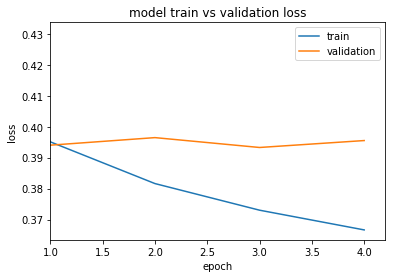

320000/320000 [==============================] - 1003s 3ms/step
score: 0.39423085
acc: 0.82381251


In [10]:
models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, batch_size = params['epoch'])
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

## LSTM with Recurrent Dropout

In [12]:
params = {
    'model_type': LSTM,
    'batch_size': 256,
    'embedding_type': 'pretrained',
    'embedding_dim': 200,
    'embedding_max_features': 20000,
    'embedding_word_index': tokenizer.word_index,
    'embedding_pretrained_zip_path': '../embeddings/glove.twitter.27B.zip',
    'embedding_pretrained_name': 'glove.twitter.27B.200d.txt',
    'epoch': 4,
    'rnn_dim': 100,
    'rnn_layer_num': 1,
    'input_length': X_train.shape[1],
    'input_dropout': 0.5,
    'recurrent_dropout': 0.5,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'is_bidirectional': True,
}

model = models.get_model(params)
history = model.fit(
    X_train, Y_train, epochs=params['epoch'], batch_size=params['batch_size'], validation_data=[X_dev, Y_dev])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 111, 200)          74377000  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 111, 200)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 402       
Total params: 74,618,202
Trainable params: 74,618,202
Non-trainable params: 0
_________________________________________________________________
None
Train on 1024000 samples, validate on 256000 samples
Epoch 1/4
1024000/1024000 [==============================] - 2237s 2ms/step - loss: 0.4465 - acc: 0.7897 - val_loss: 0.4064 - val_acc: 0.8142
Epoch 2/4
1024000/1024000 [==============================] - 2

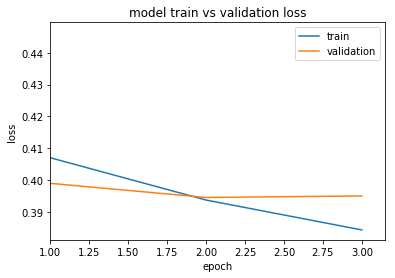

320000/320000 [==============================] - 203s 633us/step
score: 0.39376871
acc: 0.82217500


In [14]:
models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, batch_size = params['batch_size'])
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

Extracting a validation set, and measuring score and accuracy.

To improve:
1. The model is suffering from overfitting. We should add more dropout layers and try other regularization methods.
2. Systematically search for the optimal combination of hyperparameters
3. Try pretrained embedding, bidirectional RNN, combination of word and character level embedding (https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf)